## AUtoencoders

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Dense

# Загрузка данных
data = pd.read_csv('X.csv')

# Фильтрация здоровых данных (label == 0)
data_healthy = data[data['label'] == 0]

# Создание замеров по 30 записей
measurements = [data_healthy.iloc[i:i + 30] for i in range(0, len(data_healthy), 30) if len(data_healthy.iloc[i:i + 30]) == 30]

# Объединение замеров в DataFrame
train_data = pd.concat(measurements)

# Удаляем столбец label, так как он не нужен для автоэнкодера
X_train = train_data.drop(columns=['label'])

# Нормализация данных
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Определение архитектуры автоэнкодера
input_dim = X_train_scaled.shape[1]  # число фичей (признаков)

input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation="relu")(input_layer)
encoder = Dense(64, activation="relu")(encoder)
encoder = Dense(32, activation="relu")(encoder)

decoder = Dense(64, activation="relu")(encoder)
decoder = Dense(128, activation="relu")(decoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

# Обучение автоэнкодера
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=200, batch_size=32, shuffle=True)

# Тестирование на данных со сбоями
data_anomaly = data[data['label'] == 1]
X_test = data_anomaly.drop(columns=['label'])

# Нормализация тестовых данных
X_test_scaled = scaler.transform(X_test)

# Получение реконструкции данных
reconstructions = autoencoder.predict(X_test_scaled)

# Подсчет ошибок реконструкции
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# Установка порога для классификации аномалий
threshold = np.percentile(mse, 95)

# Определение аномалий
anomalies = mse > threshold
print(f"Number of detected anomalies: {np.sum(anomalies)}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv('X.csv')

# Выбираем данные с метками 1, 2, 3 (здоровые данные)
data_healthy = data[data['label'].isin([1, 2, 3])]

# Объединяем здоровые данные с тестовыми данными (сбои)
data_test = pd.concat([data_healthy, data[data['label'] == 1]])

# Убираем столбец label для подачи в автоэнкодер
X_test = data_test.drop(columns=['label'])

# Нормализация данных (используем тот же scaler, что и для тренировочных данных)
X_test_scaled = scaler.transform(X_test)

# Получаем реконструкцию данных автоэнкодером
reconstructions = autoencoder.predict(X_test_scaled)

# Вычисляем ошибку реконструкции
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# Установка порога на основе тренировочных данных
threshold = np.percentile(mse, 80)

# Определяем аномалии
anomalies = mse > threshold

# Присваиваем классы: 0 - аномалия, 1 - нормальные данные
predicted_labels = np.where(anomalies, 0, 1)

# Настоящие метки: 0 - аномалия, 1 - нормальные данные
true_labels = np.where(data_test['label'] == 1, 0, 1)

# Построение матрицы ошибок
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Визуализация матрицы ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Дополнительно: можно получить отчет по классификации
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

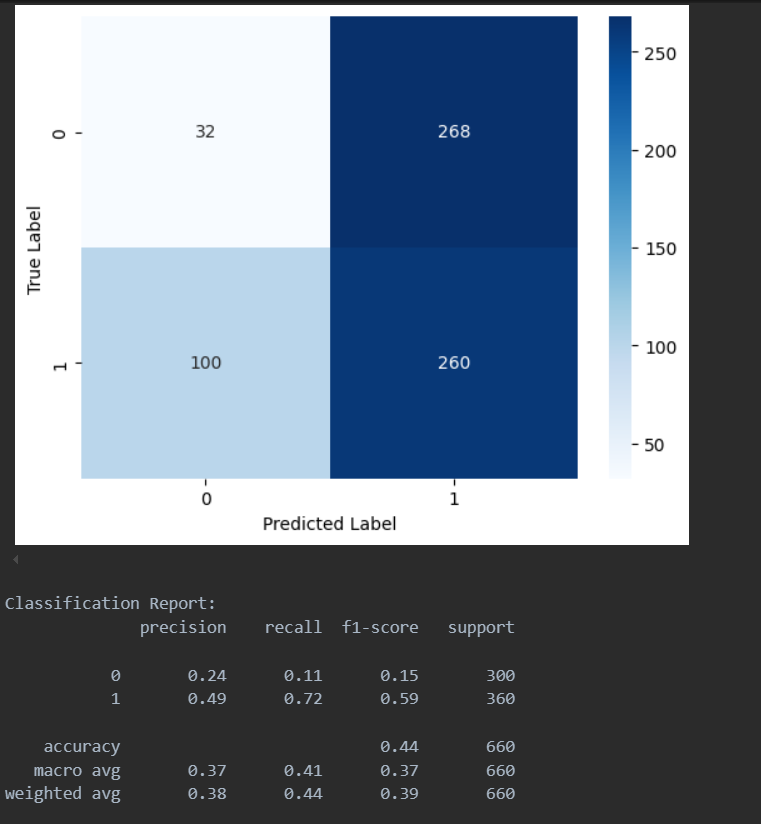

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Cropping1D, ZeroPadding1D

# Загрузка данных
data = pd.read_csv('XP.csv')

# Фильтрация здоровых данных (label == 0)
data_healthy = data[data['label'] == 0]

# Создание замеров по 30 записей
measurements = [data_healthy.iloc[i:i + 30] for i in range(0, len(data_healthy), 30) if len(data_healthy.iloc[i:i + 30]) == 30]

# Объединение замеров в DataFrame
train_data = pd.concat(measurements)

# Удаляем столбец label, так как он не нужен для автоэнкодера
X_train = train_data.drop(columns=['label'])

# Нормализация данных
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Преобразуем данные для работы со сверточной сетью
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

# Определение архитектуры сверточного автоэнкодера
input_shape = (X_train_scaled.shape[1], 1)

input_layer = Input(shape=input_shape)
encoder = Conv1D(32, 3, activation="relu", padding="same")(input_layer)
encoder = MaxPooling1D(2, padding="same")(encoder)
encoder = Conv1D(16, 3, activation="relu", padding="same")(encoder)
encoder = MaxPooling1D(2, padding="same")(encoder)
encoder = Conv1D(8, 3, activation="relu", padding="same")(encoder)

decoder = Conv1D(8, 3, activation="relu", padding="same")(encoder)
decoder = UpSampling1D(2)(decoder)
decoder = Conv1D(16, 3, activation="relu", padding="same")(decoder)
decoder = UpSampling1D(2)(decoder)
decoder = Conv1D(32, 3, activation="relu", padding="same")(decoder)

# Проверка и коррекция размеров тензоров
decoder = Conv1D(1, 3, activation="sigmoid", padding="same")(decoder)

# Если размеры не совпадают, добавить Cropping1D или ZeroPadding1D
# Пример использования Cropping1D (если выход больше на 2)
decoder = Cropping1D(cropping=(1, 1))(decoder)
# Или использовать ZeroPadding1D (если выход меньше на 2)
# decoder = ZeroPadding1D(padding=(1, 1))(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

# Разделение данных на тренировочные и валидационные
validation_split = 0.1
num_validation_samples = int(validation_split * len(X_train_scaled))

X_val_scaled = X_train_scaled[:num_validation_samples]
X_train_scaled = X_train_scaled[num_validation_samples:]

# Обучение автоэнкодера с валидационными данными
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=300, batch_size=64, shuffle=True, validation_data=(X_val_scaled, X_val_scaled))


# Тестирование на данных со сбоями
data_anomaly = data[data['label'] == 1]
X_test = data_anomaly.drop(columns=['label'])

# Нормализация тестовых данных
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Получение реконструкции данных
reconstructions = autoencoder.predict(X_test_scaled)

# Подсчет ошибок реконструкции
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=(1, 2))

# Установка порога для классификации аномалий
threshold = np.percentile(mse, 90)

# Определение аномалий
anomalies = mse > threshold
print(f"Number of detected anomalies: {np.sum(anomalies)}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv('XP.csv')

# Выбираем данные с метками 1, 2, 3 (здоровые данные)
data_healthy = data[data['label'].isin([1, 2, 3])]

# Объединяем здоровые данные с тестовыми данными (сбои)
data_test = pd.concat([data_healthy, data[data['label'] == 1]])

# Убираем столбец label для подачи в автоэнкодер
X_test = data_test.drop(columns=['label'])

# Нормализация данных (используем тот же scaler, что и для тренировочных данных)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Получаем реконструкцию данных автоэнкодером
reconstructions = autoencoder.predict(X_test_scaled)

# Вычисляем ошибку реконструкции
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=(1, 2))

# Установка порога на основе тренировочных данных
threshold = np.percentile(mse, 80)

# Определяем аномалии
anomalies = mse > threshold

# Присваиваем классы: 0 - аномалия, 1 - нормальные данные
predicted_labels = np.where(anomalies, 0, 1)

# Настоящие метки: 0 - аномалия, 1 - нормальные данные
true_labels = np.where(data_test['label'] == 1, 1, 0)

# Построение матрицы ошибок
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Визуализация матрицы ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Дополнительно: можно получить отчет по классификации
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)


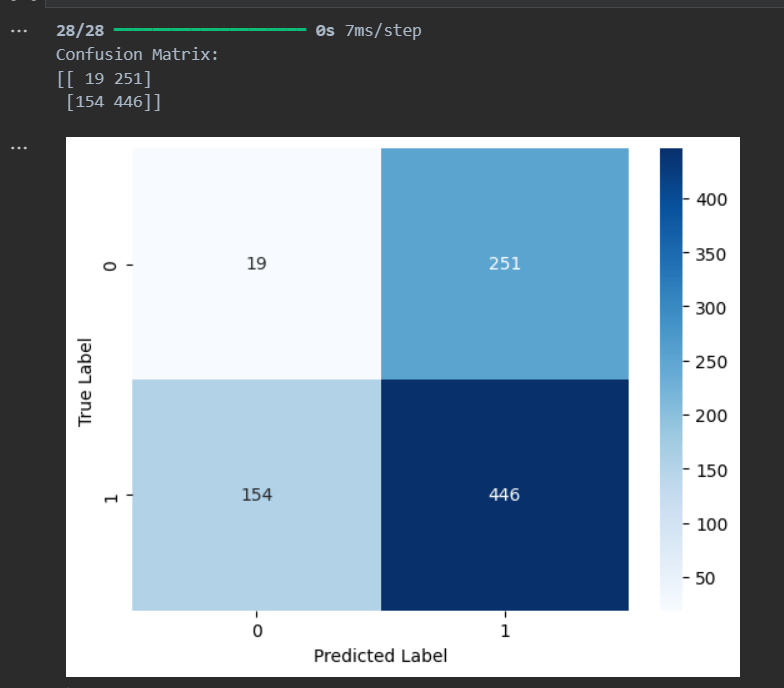

## Catboost

### Создание нового df 

#### Транспонирование 

In [ ]:
import pandas as pd
import os

# Список имен файлов
file_names = [
    'Electric_Motor-2_100_time-healthy 3-ch1.csv',
    'Electric_Motor-2_100_time-healthy 3-ch2.csv',
    'Electric_Motor-2_100_time-healthy 3-ch3.csv',
    'Electric_Motor-2_100_time-healthy 3-ch4.csv',
    'Electric_Motor-2_100_time-healthy 3-ch5.csv',
    'Electric_Motor-2_100_time-healthy 3-ch6.csv'
]

# Пустой DataFrame для хранения всех данных
all_data = pd.DataFrame()

# Проходим по каждому файлу
for file_name in file_names:
    # Считываем CSV файл
    df = pd.read_csv(file_name, header=None)
    df = df.drop(columns=[0], errors='ignore')
    # Транспонируем данные
    df_transposed = df.T
    
    # Добавляем колонку с меткой класса
    df_transposed['label'] = 0
    
    # Добавляем колонку с номером замера (от 0 до 28)
    df_transposed['measurement'] = df_transposed.index
    
    # Добавляем данные к общему DataFrame
    all_data = pd.concat([all_data, df_transposed], ignore_index=True)

# Удаляем колонку с именем "0"
all_data = all_data.drop(columns=[0], errors='ignore')

# Сохраняем объединенные данные в новый CSV файл (если нужно)
all_data.to_csv('combined_dataset_healthy.csv', index=False)

print(all_data)

In [ ]:
import pandas as pd
import os

# Список имен файлов
file_names = [
    'Electric_Motor-2_100_time-broken rotor bar-ch1.csv',
    'Electric_Motor-2_100_time-broken rotor bar-ch2.csv',
    'Electric_Motor-2_100_time-broken rotor bar-ch3.csv',
    'Electric_Motor-2_100_time-broken rotor bar-ch4.csv',
    'Electric_Motor-2_100_time-broken rotor bar-ch5.csv',
    'Electric_Motor-2_100_time-broken rotor bar-ch6.csv'
]

# Пустой DataFrame для хранения всех данных
all_data = pd.DataFrame()

# Проходим по каждому файлу
for file_name in file_names:
    # Считываем CSV файл
    df = pd.read_csv(file_name, header=None)
    
    df = df.drop(columns=[0], errors='ignore')
    # Транспонируем данные
    df_transposed = df.T
    
    # Добавляем колонку с меткой класса
    df_transposed['label'] = 1
    
    # Добавляем колонку с номером замера (от 0 до 28)
    df_transposed['measurement'] = df_transposed.index
    
    # Добавляем данные к общему DataFrame
    all_data = pd.concat([all_data, df_transposed], ignore_index=True)

# Удаляем колонку с именем "0"
all_data = all_data.drop(columns=[0], errors='ignore')

# Сохраняем объединенные данные в новый CSV файл (если нужно)
all_data.to_csv('combined_dataset_rotor_bat_broken.csv', index=False)

print(all_data)

In [ ]:
import pandas as pd
import os

# Список имен файлов
file_names = [
    r'100\bearing bpfi 3\Electric_Motor-2_100_time-bearing bpfi 3-ch1.csv',
    r'100\bearing bpfi 3\Electric_Motor-2_100_time-bearing bpfi 3-ch2.csv',
    r'100\bearing bpfi 3\Electric_Motor-2_100_time-bearing bpfi 3-ch3.csv',
    r'100\bearing bpfi 3\Electric_Motor-2_100_time-bearing bpfi 3-ch4.csv',
    r'100\bearing bpfi 3\Electric_Motor-2_100_time-bearing bpfi 3-ch5.csv',
    r'100\bearing bpfi 3\Electric_Motor-2_100_time-bearing bpfi 3-ch6.csv'
]

# Пустой DataFrame для хранения всех данных
all_data = pd.DataFrame()

# Проходим по каждому файлу
for file_name in file_names:
    # Считываем CSV файл
    df = pd.read_csv(file_name, header=None)
    
    df = df.drop(columns=[0], errors='ignore')
    # Транспонируем данные
    df_transposed = df.T
    
    # Добавляем колонку с меткой класса
    df_transposed['label'] = 2
    
    # Добавляем колонку с номером замера (от 0 до 28)
    df_transposed['measurement'] = df_transposed.index
    
    # Добавляем данные к общему DataFrame
    all_data = pd.concat([all_data, df_transposed], ignore_index=True)

# Удаляем колонку с именем "0"
all_data = all_data.drop(columns=[0], errors='ignore')

# Сохраняем объединенные данные в новый CSV файл (если нужно)
all_data.to_csv('combined_dataset_bearing bpfi 3_class_2.csv', index=False)

print(all_data)

In [ ]:
import pandas as pd
import os

# Список имен файлов
file_names = [
    r'100\bearing bpfo 3\Electric_Motor-2_100_time-bearing bpfo 3-ch1.csv',
    r'100\bearing bpfo 3\Electric_Motor-2_100_time-bearing bpfo 3-ch2.csv',
    r'100\bearing bpfo 3\Electric_Motor-2_100_time-bearing bpfo 3-ch3.csv',
    r'100\bearing bpfo 3\Electric_Motor-2_100_time-bearing bpfo 3-ch4.csv',
    r'100\bearing bpfo 3\Electric_Motor-2_100_time-bearing bpfo 3-ch5.csv',
    r'100\bearing bpfo 3\Electric_Motor-2_100_time-bearing bpfo 3-ch6.csv'
]

# Пустой DataFrame для хранения всех данных
all_data = pd.DataFrame()

# Проходим по каждому файлу
for file_name in file_names:
    # Считываем CSV файл
    df = pd.read_csv(file_name, header=None)
    
    df = df.drop(columns=[0], errors='ignore')
    # Транспонируем данные
    df_transposed = df.T
    
    # Добавляем колонку с меткой класса
    df_transposed['label'] = 3
    
    # Добавляем колонку с номером замера (от 0 до 28)
    df_transposed['measurement'] = df_transposed.index
    
    # Добавляем данные к общему DataFrame
    all_data = pd.concat([all_data, df_transposed], ignore_index=True)

# Удаляем колонку с именем "0"
all_data = all_data.drop(columns=[0], errors='ignore')

# Сохраняем объединенные данные в новый CSV файл (если нужно)
all_data.to_csv('combined_dataset_bearing bpf0 3_class_3.csv', index=False)

print(all_data)

#### Преобразование 

In [ ]:
import pandas as pd

# Загрузите ваш датафрейм
df = pd.read_csv("combined_dataset_healthy.csv")

num_data_columns = df.shape[1] - 2  # Учитываем последние две колонки: 'label' и 'measurement'
num_groups = num_data_columns // 30

# Название выходного файла
output_file = "processed_data_rotor_healthy.csv"

# Запись пустого файла для начала
# Это нужно, чтобы создать файл и при первой итерации добавить заголовки колонок
with open(output_file, 'w') as f:
    pass
print('start')
# Проходим по каждой группе из 30 колонок
for i in range(num_groups):
    # Извлекаем 30 колонок
    group_columns = df.iloc[:, i*30:(i+1)*30]
    
    # Добавляем к каждой строке 'label' и 'measurement'
    group_columns['label'] = df['label']
    group_columns['measurement'] = df['measurement']
    
    # Сохраняем текущую группу в CSV, добавляя данные в конец файла
    group_columns.to_csv(output_file, mode='a', header=(i==0), index=False)

    # Печатаем статус для отслеживания прогресса (опционально)
    print(f"Группа {i+1}/{num_groups} обработана и добавлена в файл.")

print("Обработка завершена. Все данные сохранены в", output_file)

In [ ]:
import pandas as pd

# Загрузите ваш датафрейм
df = pd.read_csv("combined\combined_dataset_bearing bpf0 3_class_3.csv")

num_data_columns = df.shape[1] - 2  # Учитываем последние две колонки: 'label' и 'measurement'
num_groups = num_data_columns // 30

# Название выходного файла
output_file = "processed_data_bearing bpf0 3_class_3.csv"

# Запись пустого файла для начала
# Это нужно, чтобы создать файл и при первой итерации добавить заголовки колонок
with open(output_file, 'w') as f:
    pass
print('start')
# Проходим по каждой группе из 30 колонок
for i in range(num_groups):
    # Извлекаем 30 колонок
    group_columns = df.iloc[:, i*30:(i+1)*30]
    
    # Добавляем к каждой строке 'label' и 'measurement'
    group_columns['label'] = df['label']
    group_columns['measurement'] = df['measurement']
    
    # Сохраняем текущую группу в CSV, добавляя данные в конец файла
    group_columns.to_csv(output_file, mode='a', header=(i==0), index=False)

    # Печатаем статус для отслеживания прогресса (опционально)
    print(f"Группа {i+1}/{num_groups} обработана и добавлена в файл.")

print("Обработка завершена. Все данные сохранены в", output_file)

In [ ]:
import pandas as pd

# Загрузите ваш датафрейм
df = pd.read_csv("combined\combined_dataset_bearing bpfi 3_class_2.csv")

num_data_columns = df.shape[1] - 2  # Учитываем последние две колонки: 'label' и 'measurement'
num_groups = num_data_columns // 30

# Название выходного файла
output_file = "processed_data_bearing bpfi 3_class_2.csv"

# Запись пустого файла для начала
# Это нужно, чтобы создать файл и при первой итерации добавить заголовки колонок
with open(output_file, 'w') as f:
    pass
print('start')
# Проходим по каждой группе из 30 колонок
for i in range(num_groups):
    # Извлекаем 30 колонок
    group_columns = df.iloc[:, i*30:(i+1)*30]
    
    # Добавляем к каждой строке 'label' и 'measurement'
    group_columns['label'] = df['label']
    group_columns['measurement'] = df['measurement']
    
    # Сохраняем текущую группу в CSV, добавляя данные в конец файла
    group_columns.to_csv(output_file, mode='a', header=(i==0), index=False)

    # Печатаем статус для отслеживания прогресса (опционально)
    print(f"Группа {i+1}/{num_groups} обработана и добавлена в файл.")

print("Обработка завершена. Все данные сохранены в", output_file)

In [ ]:
import pandas as pd

# Загрузите ваш датафрейм
df = pd.read_csv("combined_dataset_rotor_bat_broken.csv")

# Определяем количество строк и колонок в исходном датафрейме
num_rows = df.shape[0]
num_data_columns = df.shape[1] - 2  # Учитываем последние две колонки: 'label' и 'measurement'
num_groups = num_data_columns // 30

# Название выходного файла
output_file = "processed_dataset_rotor_bat_broken_.csv"

print('start')

# Проходим по каждой строке исходного датафрейма
for row_index in range(num_rows):
    row_data = df.iloc[row_index, :num_data_columns]
    label = df.iloc[row_index, -2]
    measurement = df.iloc[row_index, -1]

    # Создаем список для хранения текущих новых строк
    processed_data = []

    # Разбиваем строку на группы по 30 колонок
    for i in range(num_groups):
        new_row = row_data[i*30:(i+1)*30].tolist()
        new_row.append(label)
        new_row.append(measurement)
        processed_data.append(new_row)

    # Преобразуем текущие обработанные данные в датафрейм
    processed_df = pd.DataFrame(processed_data, columns=[f'data_{i}' for i in range(30)] + ['label', 'measurement'])

    # Сохраняем текущие обработанные данные в CSV файл
    processed_df.to_csv(output_file, mode='a', header=(row_index==0), index=False)

    # Печатаем статус для отслеживания прогресса (опционально)
    if row_index % 10 == 0:
        print(f"Строка {row_index + 1}/{num_rows} обработана и добавлена в файл.")

print("Обработка завершена. Все данные сохранены в", output_file)

#### combined_dataset_shift

In [ ]:
import pandas as pd

# Чтение вашего датасета
df = pd.read_csv('processed_data_rotor_bar_broken.csv')

# Создание новых колонок с разностями
for i in range(2, 31):
    df[f'diff_{i}'] = df[f'{i}'] - df[f'{i-1}']

# Проверка размерности
print(df.shape)

# Сохранение измененного датафрейма в новый CSV
df.to_csv('processed_data_rotor_bar_broken_with_diffs.csv', index=False)

In [ ]:
import pandas as pd

# Чтение вашего датасета
df = pd.read_csv('processed_data_rotor_healthy.csv')

# Создание новых колонок с разностями
for i in range(2, 31):
    df[f'diff_{i}'] = df[f'{i}'] - df[f'{i-1}']

# Проверка размерности
print(df.shape)

# Сохранение измененного датафрейма в новый CSV
df.to_csv('processed_data_rotor_healthy_with_diffs.csv', index=False)

In [ ]:
import pandas as pd

# Чтение вашего датасета
df = pd.read_csv('processed_data_bearing bpfi 3_class_2.csv')

# Создание новых колонок с разностями
for i in range(2, 31):
    df[f'diff_{i}'] = df[f'{i}'] - df[f'{i-1}']

# Проверка размерности
print(df.shape)

# Сохранение измененного датафрейма в новый CSV
df.to_csv('processed_data_rotor_bearing bpfi 3_with_diffs_class_2.csv', index=False)

In [ ]:
import pandas as pd

# Чтение вашего датасета
df = pd.read_csv('processed_data_bearing bpf0 3_class_3.csv')

# Создание новых колонок с разностями
for i in range(2, 31):
    df[f'diff_{i}'] = df[f'{i}'] - df[f'{i-1}']

# Проверка размерности
print(df.shape)

# Сохранение измененного датафрейма в новый CSV
df.to_csv('processed_data_rotor_bearing bpfo 3_with_diffs_class_3.csv', index=False)

#### add weiwlet 

In [ ]:

import pandas as pd
import pywt

# Чтение вашего датасета
df = pd.read_csv('processed_data_rotor_bar_broken.csv')

# Создание новых колонок с разностями
for i in range(2, 31):
    df[f'diff_{i}'] = df[f'{i}'] - df[f'{i-1}']

# Добавление вейвлет-преобразованных данных
# Выбираем вейвлет, например 'db1' (Daubechies)
wavelet = 'db2'
level = 3  # Уровень детализации, который вы хотите использовать

# Создаем массив из наблюдений для преобразования
observations = [f'{i+1}' for i in range(30)]

# Применяем вейвлет-преобразование к каждой строке
for index, row in df.iterrows():
    coeffs = pywt.wavedec(row[observations], wavelet, level=level)
    
    # coeffs[0] - это аппроксимирующие коэффициенты
    # coeffs[1], coeffs[2], ..., coeffs[level] - это детализирующие коэффициенты

    # Добавление аппроксимирующих коэффициентов
    for j, coeff in enumerate(coeffs[0]):
        df.at[index, f'approx_{j}'] = coeff

    # Добавление детализирующих коэффициентов
    for l in range(1, level + 1):
        for j, coeff in enumerate(coeffs[l]):
            df.at[index, f'detail_{l}_{j}'] = coeff

# Проверка размерности
print(df.shape)

In [ ]:


# Сохранение измененного датафрейма в новый CSV
df.to_csv('processed_data_rotor_bar_broken_with_diffs_and_wavelets_db_2_5.csv', index=False)
import pandas as pd
import pywt

# Чтение вашего датасета
df = pd.read_csv('processed_data_rotor_healthy.csv')

# Создание новых колонок с разностями
for i in range(2, 31):
    df[f'diff_{i}'] = df[f'{i}'] - df[f'{i-1}']

# Добавление вейвлет-преобразованных данных
# Выбираем вейвлет, например 'db1' (Daubechies)
wavelet = 'db2'
level = 3  # Уровень детализации, который вы хотите использовать

# Создаем массив из наблюдений для преобразования
observations = [f'{i+1}' for i in range(30)]

# Применяем вейвлет-преобразование к каждой строке
for index, row in df.iterrows():
    coeffs = pywt.wavedec(row[observations], wavelet, level=level)
    
    # coeffs[0] - это аппроксимирующие коэффициенты
    # coeffs[1], coeffs[2], ..., coeffs[level] - это детализирующие коэффициенты

    # Добавление аппроксимирующих коэффициентов
    for j, coeff in enumerate(coeffs[0]):
        df.at[index, f'approx_{j}'] = coeff

    # Добавление детализирующих коэффициентов
    for l in range(1, level + 1):
        for j, coeff in enumerate(coeffs[l]):
            df.at[index, f'detail_{l}_{j}'] = coeff

# Проверка размерности
print(df.shape)

# Сохранение измененного датафрейма в новый CSV

df.to_csv('processed_data_rotor_healthy_with_diffs_and_wavelets_db_2_5.csv', index=False)

### ТРЕНИРОВКА

In [ ]:
# Initialize CatBoostClassifier
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=1000, learning_rate = 1 )
# Fit model
model.fit(X_train, y_train,  eval_set = (X_test, y_test))

0:	learn: 0.4173829	test: 0.4175162	best: 0.4175162 (0)	total: 323ms	remaining: 5m 22s
1:	learn: 0.4163330	test: 0.4163741	best: 0.4163741 (1)	total: 579ms	remaining: 4m 48s
2:	learn: 0.4151019	test: 0.4152073	best: 0.4152073 (2)	total: 851ms	remaining: 4m 42s
3:	learn: 0.4143829	test: 0.4145608	best: 0.4145608 (3)	total: 1.08s	remaining: 4m 29s
4:	learn: 0.4137423	test: 0.4139782	best: 0.4139782 (4)	total: 1.33s	remaining: 4m 24s
5:	learn: 0.4124138	test: 0.4127298	best: 0.4127298 (5)	total: 1.58s	remaining: 4m 22s
6:	learn: 0.4116500	test: 0.4119450	best: 0.4119450 (6)	total: 1.82s	remaining: 4m 18s
7:	learn: 0.4108220	test: 0.4112180	best: 0.4112180 (7)	total: 2.09s	remaining: 4m 18s
8:	learn: 0.4098411	test: 0.4103386	best: 0.4103386 (8)	total: 2.35s	remaining: 4m 19s
9:	learn: 0.4092533	test: 0.4098317	best: 0.4098317 (9)	total: 2.61s	remaining: 4m 18s
10:	learn: 0.4090405	test: 0.4096812	best: 0.4096812 (10)	total: 2.87s	remaining: 4m 18s
11:	learn: 0.4084808	test: 0.4091617	best

Confusion Matrix:
[[302164  45836]
 [ 30693  29307]]


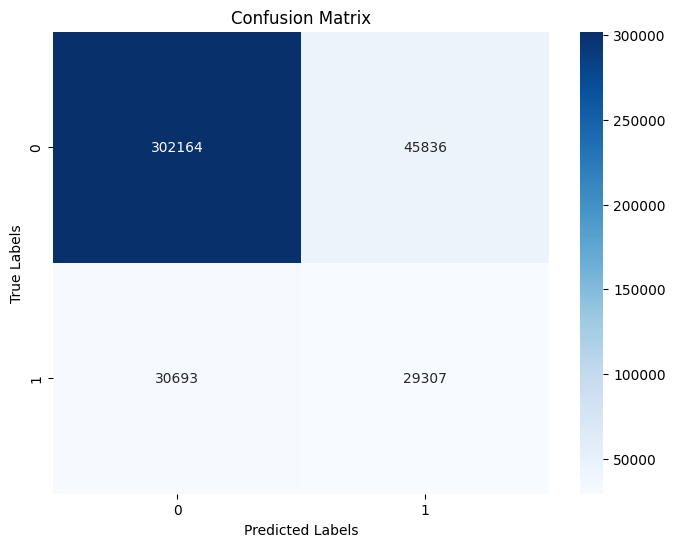


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89    348000
           1       0.39      0.49      0.43     60000

    accuracy                           0.81    408000
   macro avg       0.65      0.68      0.66    408000
weighted avg       0.83      0.81      0.82    408000



In [ ]:
# Предсказания на тестовом наборе
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = np.where(model.predict_proba(X_test)[:, 1] > 0.2, 1, 0)

# Создание матрицы ошибок (confusion matrix)
conf_matrix = confusion_matrix(y_test, y_pred)

# Вывод матрицы ошибок
print("Confusion Matrix:")
print(conf_matrix)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Дополнительно: Вывод отчета о классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузите ваши датафреймы
df_broken = pd.read_csv("processed_data_rotor_bar_broken_with_diffs.csv")
df_healthy = pd.read_csv("processed_data_rotor_healthy_with_diffs.csv")

# Добавляем колонку 'class' для различения классов

# Объединяем оба датафрейма
df_combined = pd.concat([df_broken, df_healthy], ignore_index=True)

# Удаляем колонку 'measurement'
df_combined.drop(columns=['measurement'], inplace=True)

# Разделяем данные и метки
X = df_combined.drop(columns=['label'])
y = df_combined['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Initialize CatBoostClassifier
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=1000, learning_rate = 1 )
# Fit model
model.fit(X_train, y_train,  eval_set = (X_test, y_test))

0:	learn: 0.4173195	test: 0.4173892	best: 0.4173892 (0)	total: 391ms	remaining: 6m 31s
1:	learn: 0.4163789	test: 0.4164812	best: 0.4164812 (1)	total: 661ms	remaining: 5m 30s
2:	learn: 0.4157411	test: 0.4159905	best: 0.4159905 (2)	total: 863ms	remaining: 4m 46s
3:	learn: 0.4144598	test: 0.4147595	best: 0.4147595 (3)	total: 1.12s	remaining: 4m 39s
4:	learn: 0.4139091	test: 0.4142547	best: 0.4142547 (4)	total: 1.33s	remaining: 4m 25s
5:	learn: 0.4133627	test: 0.4136997	best: 0.4136997 (5)	total: 1.56s	remaining: 4m 18s
6:	learn: 0.4129263	test: 0.4132814	best: 0.4132814 (6)	total: 1.76s	remaining: 4m 10s
7:	learn: 0.4115738	test: 0.4120540	best: 0.4120540 (7)	total: 1.99s	remaining: 4m 6s
8:	learn: 0.4110946	test: 0.4115850	best: 0.4115850 (8)	total: 2.2s	remaining: 4m 2s
9:	learn: 0.4105737	test: 0.4112486	best: 0.4112486 (9)	total: 2.41s	remaining: 3m 58s
10:	learn: 0.4101962	test: 0.4109446	best: 0.4109446 (10)	total: 2.62s	remaining: 3m 55s
11:	learn: 0.4095762	test: 0.4103143	best: 0

Confusion Matrix:
[[327689  20311]
 [ 23079  36921]]


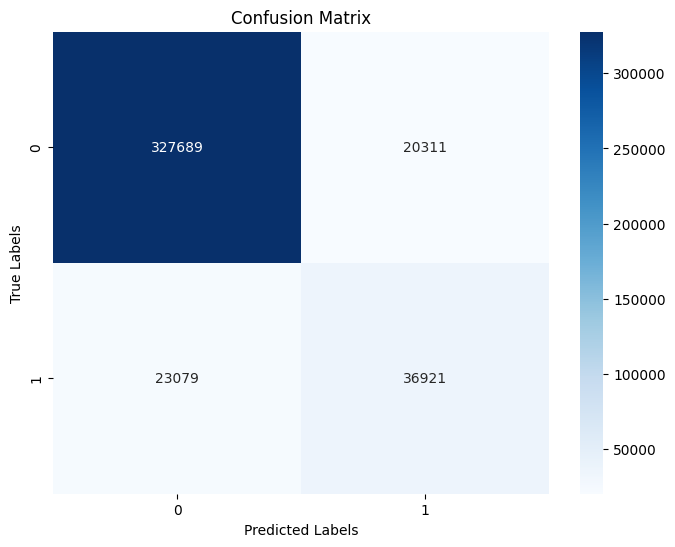


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94    348000
           1       0.65      0.62      0.63     60000

    accuracy                           0.89    408000
   macro avg       0.79      0.78      0.78    408000
weighted avg       0.89      0.89      0.89    408000



In [ ]:
# Предсказания на тестовом наборе
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = np.where(model.predict_proba(X_test)[:, 1] > 0.3, 1, 0)

# Создание матрицы ошибок (confusion matrix)
conf_matrix = confusion_matrix(y_test, y_pred)

# Вывод матрицы ошибок
print("Confusion Matrix:")
print(conf_matrix)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Дополнительно: Вывод отчета о классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузите ваши датафреймы
df_broken = pd.read_csv("processed_data_rotor_bar_broken_with_diffs_and_wavelets.csv")
df_healthy = pd.read_csv("processed_data_rotor_healthy_with_diffs_and_wavelets.csv")

# Добавляем колонку 'class' для различения классов

# Объединяем оба датафрейма
df_combined = pd.concat([df_broken, df_healthy], ignore_index=True)

# Удаляем колонку 'measurement'
df_combined.drop(columns=['measurement'], inplace=True)

# Разделяем данные и метки
X = df_combined.drop(columns=['label'])
y = df_combined['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Initialize CatBoostClassifier
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=11100, learning_rate = 1 )
# Fit model
model.fit(X_train, y_train,  eval_set = (X_test, y_test))

0:	learn: 0.4174935	test: 0.4175822	best: 0.4175822 (0)	total: 265ms	remaining: 6m 37s
1:	learn: 0.4137991	test: 0.4138473	best: 0.4138473 (1)	total: 531ms	remaining: 6m 37s
2:	learn: 0.4089124	test: 0.4091050	best: 0.4091050 (2)	total: 833ms	remaining: 6m 55s
3:	learn: 0.4046706	test: 0.4051081	best: 0.4051081 (3)	total: 1.13s	remaining: 7m 4s
4:	learn: 0.3995530	test: 0.4003390	best: 0.4003390 (4)	total: 1.42s	remaining: 7m 3s
5:	learn: 0.3956521	test: 0.3965925	best: 0.3965925 (5)	total: 1.72s	remaining: 7m 7s
6:	learn: 0.3935857	test: 0.3945591	best: 0.3945591 (6)	total: 1.98s	remaining: 7m 1s
7:	learn: 0.3915219	test: 0.3924928	best: 0.3924928 (7)	total: 2.22s	remaining: 6m 54s
8:	learn: 0.3887298	test: 0.3898565	best: 0.3898565 (8)	total: 2.51s	remaining: 6m 56s
9:	learn: 0.3863336	test: 0.3873634	best: 0.3873634 (9)	total: 2.81s	remaining: 6m 58s
10:	learn: 0.3839618	test: 0.3850346	best: 0.3850346 (10)	total: 3.1s	remaining: 7m
11:	learn: 0.3798441	test: 0.3808957	best: 0.38089

Confusion Matrix:
[[335316  12684]
 [ 23236  36764]]


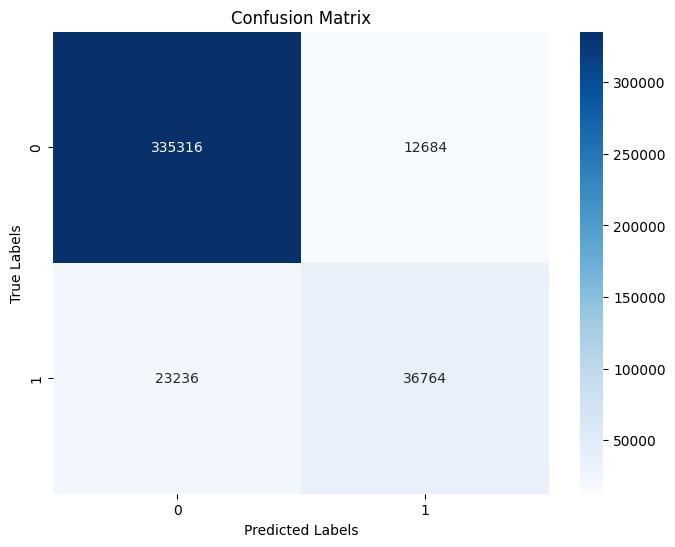


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95    348000
           1       0.74      0.61      0.67     60000

    accuracy                           0.91    408000
   macro avg       0.84      0.79      0.81    408000
weighted avg       0.91      0.91      0.91    408000



In [ ]:
# Предсказания на тестовом наборе
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = np.where(model.predict_proba(X_test)[:, 1] > 0.4, 1, 0)

# Создание матрицы ошибок (confusion matrix)
conf_matrix = confusion_matrix(y_test, y_pred)

# Вывод матрицы ошибок
print("Confusion Matrix:")
print(conf_matrix)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Дополнительно: Вывод отчета о классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузите ваши датафреймы
df_broken = pd.read_csv("processed_data_rotor_bar_broken_with_diffs_and_wavelets_db_2_5.csv")
df_healthy = pd.read_csv("processed_data_rotor_healthy_with_diffs_and_wavelets_db_2_5.csv")

# Добавляем колонку 'class' для различения классов

# Объединяем оба датафрейма
df_combined = pd.concat([df_broken, df_healthy], ignore_index=True)

# Удаляем колонку 'measurement'
df_combined.drop(columns=['measurement'], inplace=True)

# Разделяем данные и метки
X = df_combined.drop(columns=['label'])
y = df_combined['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Initialize CatBoostClassifier
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=1100, learning_rate = 1 )
# Fit model
model.fit(X_train, y_train,  eval_set = (X_test, y_test))

0:	learn: 0.4055296	test: 0.4058592	best: 0.4058592 (0)	total: 346ms	remaining: 6m 20s
1:	learn: 0.3886363	test: 0.3886815	best: 0.3886815 (1)	total: 619ms	remaining: 5m 39s
2:	learn: 0.3778541	test: 0.3774998	best: 0.3774998 (2)	total: 967ms	remaining: 5m 53s
3:	learn: 0.3676425	test: 0.3676029	best: 0.3676029 (3)	total: 1.28s	remaining: 5m 50s
4:	learn: 0.3631256	test: 0.3630527	best: 0.3630527 (4)	total: 1.58s	remaining: 5m 45s
5:	learn: 0.3570708	test: 0.3571199	best: 0.3571199 (5)	total: 1.92s	remaining: 5m 49s
6:	learn: 0.3511774	test: 0.3516049	best: 0.3516049 (6)	total: 2.19s	remaining: 5m 42s
7:	learn: 0.3462622	test: 0.3467188	best: 0.3467188 (7)	total: 2.48s	remaining: 5m 38s
8:	learn: 0.3425868	test: 0.3430735	best: 0.3430735 (8)	total: 2.75s	remaining: 5m 33s
9:	learn: 0.3393574	test: 0.3396774	best: 0.3396774 (9)	total: 2.99s	remaining: 5m 25s
10:	learn: 0.3360145	test: 0.3365146	best: 0.3365146 (10)	total: 3.26s	remaining: 5m 23s
11:	learn: 0.3317656	test: 0.3326916	best

Confusion Matrix:
[[339901   8099]
 [ 24468  35532]]


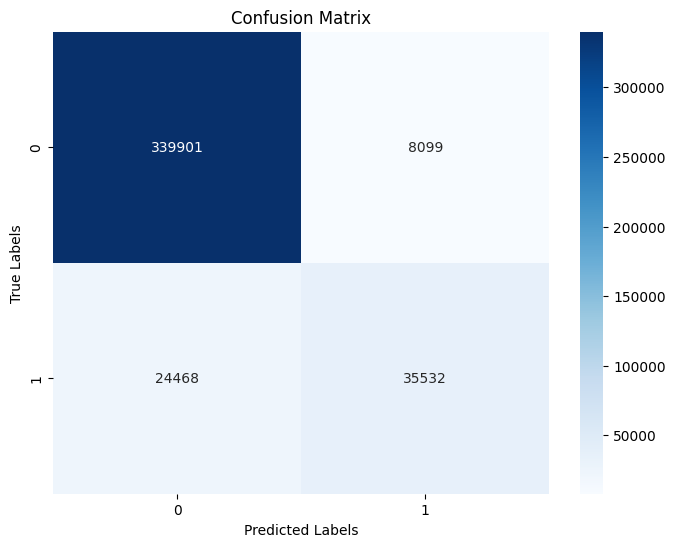


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95    348000
           1       0.81      0.59      0.69     60000

    accuracy                           0.92    408000
   macro avg       0.87      0.78      0.82    408000
weighted avg       0.92      0.92      0.91    408000



In [ ]:
# Предсказания на тестовом наборе
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = np.where(model.predict_proba(X_test)[:, 1] > 0.5, 1, 0)

# Создание матрицы ошибок (confusion matrix)
conf_matrix = confusion_matrix(y_test, y_pred)

# Вывод матрицы ошибок
print("Confusion Matrix:")
print(conf_matrix)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Дополнительно: Вывод отчета о классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### with many classes 0, 1 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузите ваши датафреймы
df_broken_bar = pd.read_csv("processed_data_rotor_bar_broken_with_diffs.csv")
df_broken_bar = pd.read_csv("processed_data_rotor_bar_broken_with_diffs.csv")
df_broken_bpfi = pd.read_csv("processed_data_bearing bpfi 3.csv")
df_broken_bpf0 = pd.read_csv("processed_data_bearing bpf0 3.csv")

# Добавляем колонку 'class' для различения классов

# Объединяем оба датафрейма
df_combined = pd.concat([df_broken, df_healthy,df_broken_bpfi,df_broken_bpf0], ignore_index=True)

# Удаляем колонку 'measurement'
df_combined.drop(columns=['measurement'], inplace=True)

# Разделяем данные и метки
X = df_combined.drop(columns=['label'])
y = df_combined['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Initialize CatBoostClassifier
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=1100 )
# Fit model
model.fit(X_train, y_train,  eval_set = (X_test, y_test))

Learning rate set to 0.203644
0:	learn: 0.4631925	test: 0.4627596	best: 0.4627596 (0)	total: 476ms	remaining: 8m 43s
1:	learn: 0.3869212	test: 0.3862312	best: 0.3862312 (1)	total: 724ms	remaining: 6m 37s
2:	learn: 0.3490214	test: 0.3481572	best: 0.3481572 (2)	total: 1.2s	remaining: 7m 17s
3:	learn: 0.3279145	test: 0.3270071	best: 0.3270071 (3)	total: 1.65s	remaining: 7m 31s
4:	learn: 0.3151516	test: 0.3141551	best: 0.3141551 (4)	total: 2.06s	remaining: 7m 31s
5:	learn: 0.3059111	test: 0.3048502	best: 0.3048502 (5)	total: 2.52s	remaining: 7m 39s
6:	learn: 0.2990881	test: 0.2980780	best: 0.2980780 (6)	total: 3.04s	remaining: 7m 54s
7:	learn: 0.2934944	test: 0.2925513	best: 0.2925513 (7)	total: 3.56s	remaining: 8m 5s
8:	learn: 0.2890193	test: 0.2880534	best: 0.2880534 (8)	total: 4.04s	remaining: 8m 9s
9:	learn: 0.2851873	test: 0.2842313	best: 0.2842313 (9)	total: 4.44s	remaining: 8m 3s
10:	learn: 0.2823418	test: 0.2813418	best: 0.2813418 (10)	total: 4.89s	remaining: 8m 4s
11:	learn: 0.280

Confusion Matrix:
[[345645   2355]
 [ 31176 172824]]


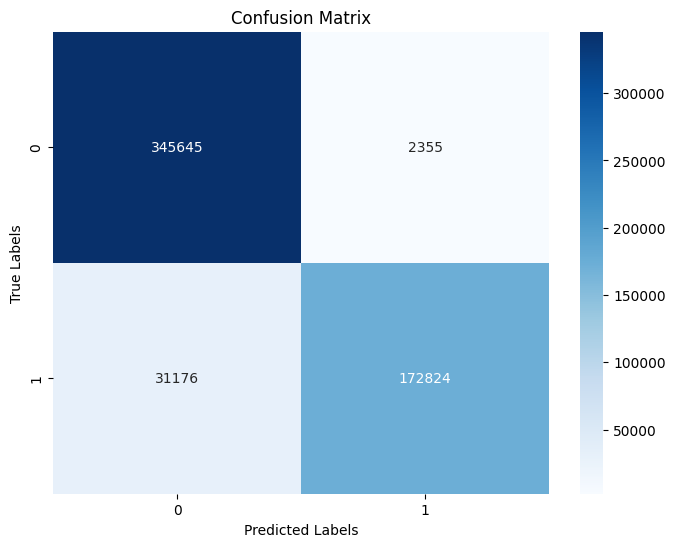


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95    348000
           1       0.99      0.85      0.91    204000

    accuracy                           0.94    552000
   macro avg       0.95      0.92      0.93    552000
weighted avg       0.94      0.94      0.94    552000



In [ ]:
# Предсказания на тестовом наборе
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = np.where(model.predict_proba(X_test)[:, 1] > 0.5, 1, 0)

# Создание матрицы ошибок (confusion matrix)
conf_matrix = confusion_matrix(y_test, y_pred)

# Вывод матрицы ошибок
print("Confusion Matrix:")
print(conf_matrix)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Дополнительно: Вывод отчета о классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

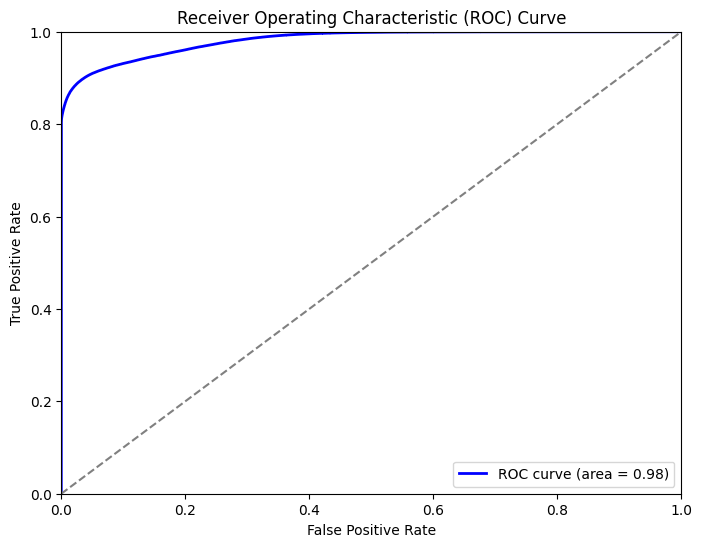

In [ ]:
from sklearn.metrics import roc_curve, auc

# Получение вероятностей для положительного класса
y_prob = model.predict_proba(X_test)[:, 1]

# Построение ROC кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Визуализация ROC кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайного классификатора
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузите ваши датафреймы
df_broken_bar = pd.read_csv("nik_processed_file/processed_data_rotor_bar_broken_with_diffs.csv")
df_broken_healthy = pd.read_csv("nik_processed_file/processed_data_rotor_healthy_with_diffs.csv")
df_broken_bpfi = pd.read_csv("nik_processed_file/processed_data_rotor_bearing bpfi 3_with_diffs_class_2.csv")
df_broken_bpf0 = pd.read_csv("nik_processed_file/processed_data_rotor_bearing bpfo 3_with_diffs_class_3.csv")
df_broken_bpf0_2 = pd.read_csv("processed_data_rotor_bearing bpfo 2_with_diffs_class_3.csv")
df_broken_bpfi_2 = pd.read_csv("processed_data_rotor_bearing bpfi 2_with_diffs_class_2.csv")
df_broken_bpf0_1 = pd.read_csv("processed_data_rotor_bearing bpfo 1_with_diffs_class_3.csv")
df_broken_bpfi_1 = pd.read_csv("processed_data_rotor_bearing bpfi 1_with_diffs_class_2.csv")
# Добавляем колонку 'class' для различения классов

# Объединяем оба датафрейма
df_combined = pd.concat([df_broken_bar, df_broken_healthy,df_broken_bpfi,df_broken_bpf0,df_broken_bpfi_2,df_broken_bpf0_2,df_broken_bpf0_1,df_broken_bpfi_1], ignore_index=True)

# Удаляем колонку 'measurement'
df_combined.drop(columns=['measurement'], inplace=True)

# Разделяем данные и метки
X = df_combined.drop(columns=['label'])
y = df_combined['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
class_couvnts = df_combined['label'].value_counts()
print(class_counts)

label
0    1740000
3     840000
2     600000
1     300000
Name: count, dtype: int6

In [ ]:
# Initialize CatBoostClassifier
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=2000, loss_function='MultiClass', task_type="GPU", devices='0')
# Fit model
model.fit(X_train, y_train,  eval_set = (X_test, y_test))

In [ ]:
# Предсказания на тестовом наборе
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)

# Создание матрицы ошибок (confusion matrix)
conf_matrix = confusion_matrix(y_test, y_pred)

# Вывод матрицы ошибок
print("Confusion Matrix:")
print(conf_matrix)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Дополнительно: Вывод отчета о классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

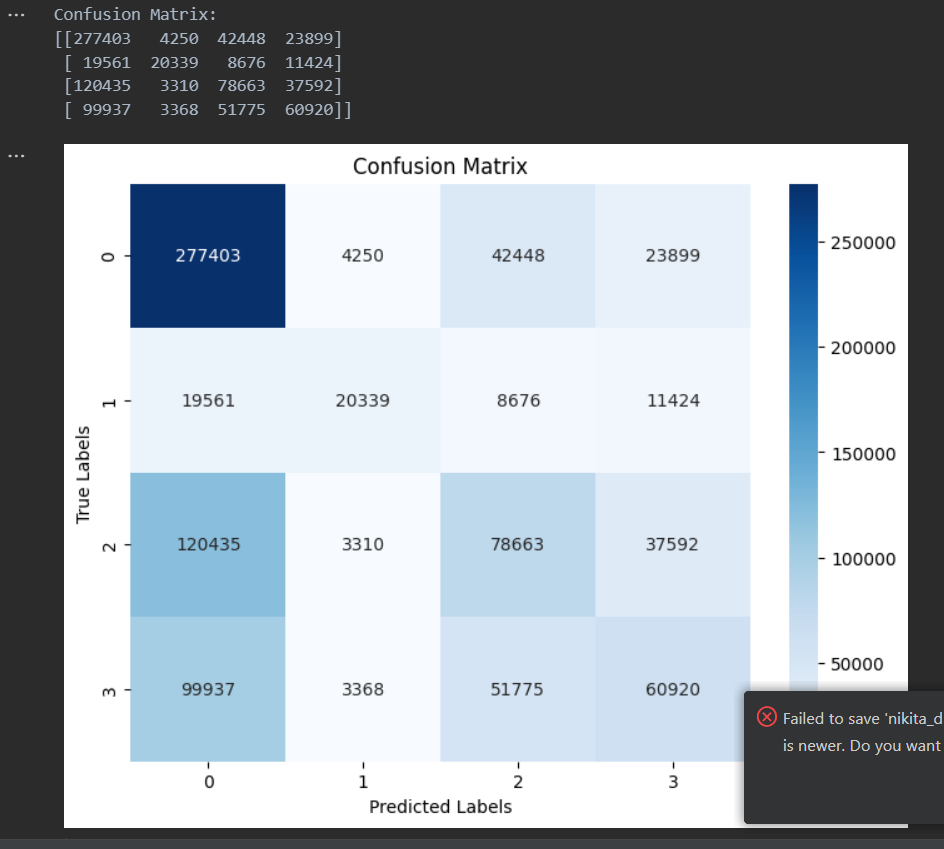

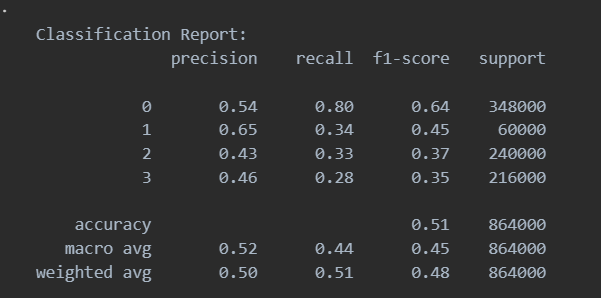